<a id='top'></a>
### Table of contents:  

[Adding country names to the data set](#countries)  

[Adding missing prices using exchange rate data](#exchange)   

[Adding missing coordinates](#coordinates)

[Aggregating average price for the same product-day-market-country](#agg)  


In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import pearsonr
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import scale
from pylab import rcParams
import matplotlib.ticker as mt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [2]:
path=r'C:\Users\frauz\Documents\Python Projects\Final Project\Data\Data Prepared' #creating a path

df_food=pd.read_pickle(os.path.join(path,'all_products_prices_market_unaggregated.pkl')) #importing data
df_exchange=pd.read_pickle(os.path.join(path,'wfp_exchange_rate.pkl'))

In [3]:
df_food.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2686505 entries, 2 to 2726300
Data columns (total 16 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   market         object        
 2   latitude       float64       
 3   longitude      float64       
 4   category       object        
 5   commodity      object        
 6   unit           object        
 7   pricetype      object        
 8   currency       object        
 9   price          float64       
 10  usdprice       float64       
 11  iso            object        
 12  measure_unit   object        
 13  product_name   object        
 14  price_unit     float64       
 15  usdprice_unit  float64       
dtypes: datetime64[ns](1), float64(6), object(9)
memory usage: 348.4+ MB


In [4]:
df_exchange.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15600 entries, 4023 to 2658228
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       15600 non-null  datetime64[ns]
 1   market     15600 non-null  object        
 2   latitude   15267 non-null  float64       
 3   longitude  15267 non-null  float64       
 4   category   15600 non-null  object        
 5   commodity  15600 non-null  object        
 6   unit       15600 non-null  object        
 7   currency   15600 non-null  object        
 8   price      15600 non-null  float64       
 9   usdprice   15436 non-null  float64       
 10  iso        15600 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 1.4+ MB


<a id='countries'></a>
### Adding country names to the data set
[Back to top](#top)

In [5]:
df_food.isnull().sum()

date                 0
market               0
latitude         23738
longitude        23738
category             0
commodity            0
unit                 0
pricetype            0
currency             0
price                0
usdprice          2576
iso                  0
measure_unit         0
product_name         0
price_unit        5859
usdprice_unit     2576
dtype: int64

In [6]:
df_food.head()

,date,market,latitude,longitude,category,commodity,unit,pricetype,currency,price,usdprice,iso,measure_unit,product_name,price_unit,usdprice_unit
2,2000-01-15,Hirat,34.346944,62.198333,cereals and tubers,Bread,KG,Retail,AFN,15.63,0.3340,AFG,KG,Bread,15.63,0.3340
3,2000-01-15,Hirat,34.346944,62.198333,cereals and tubers,Wheat,KG,Retail,AFN,9.13,0.1951,AFG,KG,Wheat,9.13,0.1951
4,2000-01-15,Hirat,34.346944,62.198333,cereals and tubers,Wheat flour,KG,Retail,AFN,10.06,0.2150,AFG,KG,Wheat flour,10.06,0.2150
6,2000-01-15,Kabul,34.516667,69.183333,cereals and tubers,Bread,KG,Retail,AFN,14.26,0.3048,AFG,KG,Bread,14.26,0.3048
7,2000-01-15,Kabul,34.516667,69.183333,cereals and tubers,Wheat,KG,Retail,AFN,13.75,0.2939,AFG,KG,Wheat,13.75,0.2939


In [7]:
# Importing the data set that has both country names and iso codes

df_merged=pd.read_pickle(os.path.join(path,'data_merged_no_var.pkl')) #importing data


In [8]:
df_merged.head()

,iso,date,category,currency,product_name,price_unit,usdprice_unit,year,month,population,millions_undernourished,country,earnings_currency,inflation,gdp_pcapita
0,AFG,2000-01-15,cereals and tubers,AFN,Bread,15.2500,0.325925,2000,01,NaN,NaN,Afghanistan,NaN,NaN,NaN
1,AFG,2000-01-15,cereals and tubers,AFN,Wheat,12.2300,0.261400,2000,01,NaN,NaN,Afghanistan,NaN,NaN,NaN
2,AFG,2000-01-15,cereals and tubers,AFN,Wheat flour,15.5450,0.332225,2000,01,NaN,NaN,Afghanistan,NaN,NaN,NaN
3,AFG,2000-02-15,cereals and tubers,AFN,Bread,15.3000,0.324425,2000,02,NaN,NaN,Afghanistan,NaN,NaN,NaN
4,AFG,2000-02-15,cereals and tubers,AFN,Wheat,11.7475,0.249075,2000,02,NaN,NaN,Afghanistan,NaN,NaN,NaN


In [9]:
#Creating dataframe with country names and iso

df_country=df_merged[['iso','country']]

In [10]:
df_country.drop_duplicates(inplace=True)
df_country

,iso,country
0,AFG,Afghanistan
1232,AGO,Angola
2381,ARG,Argentina
2899,ARM,Armenia
5804,AZE,Azerbaijan
...,...,...
126630,UGA,Uganda
127978,UKR,Ukraine
130175,YEM,"Yemen, Rep."
132239,ZMB,Zambia


In [11]:
df_food_country=df_food.merge(df_country, on='iso', how='left')

In [12]:
df_food_country.isnull().sum()

date                 0
market               0
latitude         23738
longitude        23738
category             0
commodity            0
unit                 0
pricetype            0
currency             0
price                0
usdprice          2576
iso                  0
measure_unit         0
product_name         0
price_unit        5859
usdprice_unit     2576
country          57609
dtype: int64

In [13]:
# Checking missing country names

list_missing=df_food_country['iso'][df_food_country['country'].isnull()].unique()
list_missing  #11 countries are still missing

array(['CHN', 'COL', 'CRI', 'ECU', 'HND', 'PRY', 'RUS', 'THA', 'VNM',
       'ZAF'], dtype=object)

In [14]:
# Imporing World Bank population data that contains both iso and country names

df_pop=pd.read_pickle(os.path.join(path, 'population_undernourished.pkl'))

In [15]:
df_pop_names=df_pop[['iso','country']][df_pop['iso'].isin(list_missing)]

In [16]:
df_pop_names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 1196 to 6733
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   iso      260 non-null    object
 1   country  260 non-null    object
dtypes: object(2)
memory usage: 6.1+ KB


In [17]:
df_pop_names.drop_duplicates(inplace=True)
df_pop_names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1196 to 6708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   iso      10 non-null     object
 1   country  10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


In [18]:
df_food_country_names=df_food_country.merge(df_pop_names, on='iso',how='left')

In [19]:
df_food_country_names.isnull().sum()

date                   0
market                 0
latitude           23738
longitude          23738
category               0
commodity              0
unit                   0
pricetype              0
currency               0
price                  0
usdprice            2576
iso                    0
measure_unit           0
product_name           0
price_unit          5859
usdprice_unit       2576
country_x          57609
country_y        2628896
dtype: int64

In [20]:
# Checking the result

df_food_country_names[df_food_country_names['country_x'].isnull()]

,date,market,latitude,longitude,category,commodity,unit,pricetype,currency,price,usdprice,iso,measure_unit,product_name,price_unit,usdprice_unit,country_x,country_y
308669,2014-01-15,Sijiazhuang,38.040,114.510,cereals and tubers,Wheat,KG,Wholesale,CNY,2.66,0.4405,CHN,KG,Wheat,2.66,0.4405,NaN,"China, Taiwan Province of"
308670,2014-01-15,Heilongjiang,45.750,126.630,cereals and tubers,Maize,KG,Wholesale,CNY,2.17,0.3598,CHN,KG,Maize,2.17,0.3598,NaN,"China, Taiwan Province of"
308671,2014-01-15,Zhengzhou,34.770,113.650,cereals and tubers,Wheat,KG,Wholesale,CNY,2.55,0.4228,CHN,KG,Wheat,2.55,0.4228,NaN,"China, Taiwan Province of"
308672,2014-01-15,Hubei,30.970,112.230,cereals and tubers,Rice (Indica),KG,Wholesale,CNY,3.92,0.6500,CHN,KG,Rice,3.92,0.6500,NaN,"China, Taiwan Province of"
308673,2014-01-15,Wuhan,30.580,114.280,cereals and tubers,Rice (Japonica),KG,Wholesale,CNY,4.40,0.7295,CHN,KG,Rice,4.40,0.7295,NaN,"China, Taiwan Province of"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619238,2022-05-15,Randfontein,-26.199,27.669,cereals and tubers,Maize (yellow),KG,Wholesale,ZAR,4.86,0.3088,ZAF,KG,Maize,4.86,0.3088,NaN,South Africa
2619239,2022-05-15,Randfontein,-26.199,27.669,cereals and tubers,Wheat,KG,Wholesale,ZAR,8.02,0.5096,ZAF,KG,Wheat,8.02,0.5096,NaN,South Africa
2619240,2022-06-15,Randfontein,-26.199,27.669,cereals and tubers,Maize (white),KG,Wholesale,ZAR,4.42,0.2760,ZAF,KG,Maize,4.42,0.2760,NaN,South Africa
2619241,2022-06-15,Randfontein,-26.199,27.669,cereals and tubers,Maize (yellow),KG,Wholesale,ZAR,4.47,0.2791,ZAF,KG,Maize,4.47,0.2791,NaN,South Africa


In [21]:
df_food_country_names.loc[df_food_country_names['country_x'].isnull(), 'country_x']=df_food_country_names['country_y']

In [22]:
df_food_country_names.drop(columns=['country_y'], inplace=True)

In [23]:
df_food_country_names.rename(columns=({'country_x':'country'}), inplace=True)

In [24]:
df_food_country_names.isnull().sum()

date                 0
market               0
latitude         23738
longitude        23738
category             0
commodity            0
unit                 0
pricetype            0
currency             0
price                0
usdprice          2576
iso                  0
measure_unit         0
product_name         0
price_unit        5859
usdprice_unit     2576
country              0
dtype: int64

<a id='exchange'></a>
### Adding missing prices using exchange rate data
[Back to top](#top)

In [25]:
# I will try to calculate missing prices using exchange rates

df_exchange['iso'].value_counts() #unfortunately, WFP database only contains a few exchange rates

SYR    3581
COD    2795
YEM    2011
AFG    1912
SOM    1701
LBR    1024
SSD     866
TJK     694
IRQ     558
ETH     151
SDN      98
LBY      49
VEN      49
ARM      38
LBN      38
TCD      35
Name: iso, dtype: int64

In [26]:
# Importing external exchange rate data set

path1=r'C:\Users\frauz\Documents\Python Projects\Final Project\Data' #creating a path

df_rate=pd.read_csv(os.path.join(path1,'exchange_rate.csv'), index_col=False) #exporting the dataset

In [27]:
# Checking what countries are missing either price in local currency or price in USD or either of the prices are 0

df_missing=df_food_country_names.loc[(df_food_country_names['price_unit'].isnull())|
                       (df_food_country_names['usdprice_unit'].isnull())|
                      (df_food_country_names['price_unit']==0)|
                      (df_food_country_names['usdprice_unit']==0)]

df_missing['country'].value_counts() # There are 6 countries where prices are missing or usd_price is 0

Nicaragua    5090
Somalia      2576
Honduras      611
Belarus       276
Panama        158
Name: country, dtype: int64

In [28]:
# Checking if the exchange rate dataset contains the countries I need

df_rate.head()

,Record Date,Country,Currency,Country - Currency Description,Exchange Rate,Effective Date,Source Line Number,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number
0,2023-06-30,Chile,Peso,Chile-Peso,887.600,2023-09-15,36,2023,3,2023,2,6,30
1,2023-06-30,Argentina,Peso,Argentina-Peso,365.500,2023-08-15,7,2023,3,2023,2,6,30
2,2023-06-30,Belarus,New Ruble,Belarus-New Ruble,3.265,2023-08-15,16,2023,3,2023,2,6,30
3,2023-06-30,Myanmar,Kyat,Myanmar-Kyat,2918.000,2023-08-15,108,2023,3,2023,2,6,30
4,2023-06-30,Russia,Ruble,Russia-Ruble,98.855,2023-08-15,130,2023,3,2023,2,6,30


In [29]:
df_rate.duplicated().sum()

0

In [30]:
country_names=set(df_rate['Country'].to_list())
country_names

{'AFGHANISTAN',
 'ALBANIA',
 'ALGERIA',
 'ANGOLA',
 'ANTIGUA',
 'ARGENTINA',
 'ARMENIA',
 'AUSTRALIA',
 'AUSTRIA',
 'AZERBAIJAN',
 'Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antigua & Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaidjan',
 'Azerbaijan',
 'BAHAMAS',
 'BAHRAIN',
 'BANGLADESH',
 'BARBADOS',
 'BELARUS',
 'BELGIUM',
 'BELIZE',
 'BENIN',
 'BERMUDA',
 'BOLIVIA',
 'BOSNIA',
 'BOTSWANA',
 'BRAZIL',
 'BRUNEI',
 'BULGARIA',
 'BURKINA FASO',
 'BURMA',
 'BURUNDI',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belaruse',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bolivia',
 'Bosnia',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'CAMBODIA (KHMER)',
 'CAMEROON',
 'CANADA',
 'CAPE VERDE',
 'CAYMAN ISLANDS',
 'CENTRAL AFRICAN REPUBLIC',
 'CHAD',
 'CHILE',
 'CHINA',
 'COLOMBIA',
 'COMOROS',
 'CONGO',
 'CONGO, DEM. REP',
 'COSTA RICA',
 "COTE D'IVOIRE",
 'CROATIA',
 'CUBA',
 'CYPRUS',
 'CZEC

In [31]:
# Country names in the data set are recorded in proper and upper case. I need to transform all to proper case

df_rate['Country']=df_rate['Country'].str.capitalize()
df_rate['Currency']=df_rate['Currency'].str.capitalize()

In [32]:
df_rate.duplicated().sum()

0

In [33]:
# What countries do I need

countries_need=set(df_missing['country'].to_list())
countries_need

{'Belarus', 'Honduras', 'Nicaragua', 'Panama', 'Somalia'}

In [34]:
# What do I already have

set(country_names).intersection(countries_need)

{'Belarus', 'Honduras', 'Nicaragua', 'Panama'}

In [35]:
# Both Venezuela and Somalia are also present but spelled differently

# Isolating the records that contain exchange rate for the countries I need



df_rate_need=df_rate.loc[(df_rate['Country'].str.contains('Somali'))|(df_rate['Country'].isin(list(countries_need)))]
df_rate_need.head()

,Record Date,Country,Currency,Country - Currency Description,Exchange Rate,Effective Date,Source Line Number,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number
2,2023-06-30,Belarus,New ruble,Belarus-New Ruble,3.265,2023-08-15,16,2023,3,2023,2,6,30
24,2023-06-30,Belarus,New ruble,Belarus-New Ruble,2.933,2023-06-30,15,2023,3,2023,2,6,30
77,2023-06-30,Honduras,Lempira,Honduras-Lempira,24.566,2023-06-30,70,2023,3,2023,2,6,30
118,2023-06-30,Nicaragua,Cordoba,Nicaragua-Cordoba,36.400,2023-06-30,113,2023,3,2023,2,6,30
125,2023-06-30,Panama,Dolares,Panama-Dolares,1.000,2023-06-30,120,2023,3,2023,2,6,30


In [36]:
df_rate_need['Country'].value_counts()

Panama       97
Belarus      96
Honduras     90
Nicaragua    90
Somali       24
Name: Country, dtype: int64

In [37]:
# Changing mismatched country names

df_rate_need['Country'].replace('Somali','Somalia',inplace=True)
df_food_country_names['country'].replace('Venezuela (Bolivarian Republic of)','Venezuela', inplace=True)

In [38]:
df_rate_need['Effective Date']=pd.to_datetime(df_rate_need['Effective Date'])
df_rate_need['Effective Date'].dtype

dtype('<M8[ns]')

In [39]:
# Creating a year-month column in both dataframes

df_food_country_names['year_month']=df_food_country_names['date'].dt.strftime('%Y-%m')
df_rate_need['year_month']=df_rate_need['Effective Date'].dt.strftime('%Y-%m')

In [40]:
df_rate_need.head()

,Record Date,Country,Currency,Country - Currency Description,Exchange Rate,Effective Date,Source Line Number,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number,year_month
2,2023-06-30,Belarus,New ruble,Belarus-New Ruble,3.265,2023-08-15,16,2023,3,2023,2,6,30,2023-08
24,2023-06-30,Belarus,New ruble,Belarus-New Ruble,2.933,2023-06-30,15,2023,3,2023,2,6,30,2023-06
77,2023-06-30,Honduras,Lempira,Honduras-Lempira,24.566,2023-06-30,70,2023,3,2023,2,6,30,2023-06
118,2023-06-30,Nicaragua,Cordoba,Nicaragua-Cordoba,36.400,2023-06-30,113,2023,3,2023,2,6,30,2023-06
125,2023-06-30,Panama,Dolares,Panama-Dolares,1.000,2023-06-30,120,2023,3,2023,2,6,30,2023-06


In [41]:
df_food_country_names.head()

,date,market,latitude,longitude,category,commodity,unit,pricetype,currency,price,usdprice,iso,measure_unit,product_name,price_unit,usdprice_unit,country,year_month
0,2000-01-15,Hirat,34.346944,62.198333,cereals and tubers,Bread,KG,Retail,AFN,15.63,0.3340,AFG,KG,Bread,15.63,0.3340,Afghanistan,2000-01
1,2000-01-15,Hirat,34.346944,62.198333,cereals and tubers,Wheat,KG,Retail,AFN,9.13,0.1951,AFG,KG,Wheat,9.13,0.1951,Afghanistan,2000-01
2,2000-01-15,Hirat,34.346944,62.198333,cereals and tubers,Wheat flour,KG,Retail,AFN,10.06,0.2150,AFG,KG,Wheat flour,10.06,0.2150,Afghanistan,2000-01
3,2000-01-15,Kabul,34.516667,69.183333,cereals and tubers,Bread,KG,Retail,AFN,14.26,0.3048,AFG,KG,Bread,14.26,0.3048,Afghanistan,2000-01
4,2000-01-15,Kabul,34.516667,69.183333,cereals and tubers,Wheat,KG,Retail,AFN,13.75,0.2939,AFG,KG,Wheat,13.75,0.2939,Afghanistan,2000-01


In [42]:
# Checking duplicates for exchange rates

df_rate_final=df_rate_need[['Country','year_month','Currency','Effective Date','Exchange Rate']]
df_rate_final.duplicated().sum()                     

0

In [43]:
# Dropping duplicates

df_rate_final.drop_duplicates(inplace=True)
df_rate_final.duplicated().sum() 

0

In [44]:
df_rate_final.rename(columns={'Country':'country','Exchange Rate':'exchange_rate','Currency':'currency','Effective Date':'date'}, inplace=True)

In [45]:
df_rate_final['double']=df_rate_final.groupby(['year_month','country'])['exchange_rate'].transform(np.size)
df_double=df_rate_final.loc[df_rate_final['double']>1]
df_double[['country','currency']].value_counts()

country  currency 
Panama   Balboa       7
         Dolares      7
Belarus  New ruble    5
         Ruble        5
dtype: int64

In [46]:
# 2 countries have different currencies used in the exchange rate dataframe. How is it in price dataframe?

df_curr=df_food_country_names.loc[df_food_country_names['country'].isin(['Panama','Belarus','Honduras','Nicaragua','Somalia'])]
df_curr['currency'].value_counts()

SOS    21666
NIO     8151
PAB     2158
HNL     1589
BYR      483
Name: currency, dtype: int64

In [47]:
df_bel=df_food_country_names.loc[df_food_country_names['country']=='Belarus']

<Axes: ylabel='Frequency'>

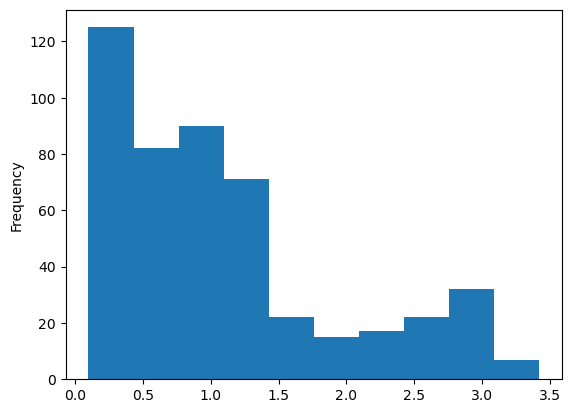

In [48]:
df_bel['price_unit'].plot(kind='hist')
# Judjung by the price values, all prices in the dataset prices are recorded in new rubel currency 

In [49]:
#Replacing Belarusian currency with the new one where applicable

df_food_country_names.loc[(df_food_country_names['country']=='Belarus'),'currency']='BYN'


In [50]:
# Replacing currency names to use them for matching the data

df_rate_final.loc[(df_rate_final['country']=='Belarus')&
                         (df_rate_final['currency'].isin(['NEW RUBLE','New Ruble'])),'currency']='BYN'
df_rate_final.loc[(df_rate_final['country']=='Belarus')&
                         (df_rate_final['currency'].isin(['RUBLE','Ruble'])),'currency']='BYR'

In [51]:
df_rate_final['currency'][df_rate_final['country'].isin(['Panama','Somalia','Nicaragua','Honduras'])].value_counts()

Lempira     90
Cordoba     90
Balboa      82
Shilling    24
Dolares     15
Name: currency, dtype: int64

In [52]:
df_rate_final['currency'].replace('Balboa','PAB',inplace=True)
df_rate_final['currency'].replace('Lempira','HNL',inplace=True)
df_rate_final['currency'].replace('Shilling','SOS',inplace=True)
df_rate_final['currency'].replace('Cordoba','NIO',inplace=True)

In [53]:
# Adding exchange rate to the foodptice dataset

df_price_ex=df_food_country_names.merge(df_rate_final[['country','year_month','currency','exchange_rate']], how='left', on=['country','year_month','currency'])

In [54]:
df_price_ex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2686505 entries, 0 to 2686504
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   market         object        
 2   latitude       float64       
 3   longitude      float64       
 4   category       object        
 5   commodity      object        
 6   unit           object        
 7   pricetype      object        
 8   currency       object        
 9   price          float64       
 10  usdprice       float64       
 11  iso            object        
 12  measure_unit   object        
 13  product_name   object        
 14  price_unit     float64       
 15  usdprice_unit  float64       
 16  country        object        
 17  year_month     object        
 18  exchange_rate  float64       
dtypes: datetime64[ns](1), float64(7), object(11)
memory usage: 409.9+ MB


In [55]:
df_price_ex.isnull().sum()

date                   0
market                 0
latitude           23738
longitude          23738
category               0
commodity              0
unit                   0
pricetype              0
currency               0
price                  0
usdprice            2576
iso                    0
measure_unit           0
product_name           0
price_unit          5859
usdprice_unit       2576
country                0
year_month             0
exchange_rate    2678970
dtype: int64

In [56]:
df_price_ex[df_price_ex['exchange_rate'].notnull()]

,date,market,latitude,longitude,category,commodity,unit,pricetype,currency,price,usdprice,iso,measure_unit,product_name,price_unit,usdprice_unit,country,year_month,exchange_rate
761820,2007-03-15,San Pedro Sula,15.500000,-88.033000,cereals and tubers,Maize (white),46 KG,Wholesale,HNL,279.50,15.4377,HND,KG,Maize,6.076087,0.335602,Honduras,2007-03,18.95
761821,2007-03-15,San Pedro Sula,15.500000,-88.033000,cereals and tubers,"Rice (ordinary, second quality)",46 KG,Wholesale,HNL,530.00,29.2737,HND,KG,Rice,11.521739,0.636385,Honduras,2007-03,18.95
761822,2007-03-15,San Pedro Sula,15.500000,-88.033000,pulses and nuts,Beans (red),46 KG,Wholesale,HNL,544.00,30.0469,HND,KG,Beans,11.826087,0.653193,Honduras,2007-03,18.95
761823,2007-03-15,Tegucigalpa,14.102757,-87.210378,cereals and tubers,Maize (white),46 KG,Wholesale,HNL,254.00,14.0293,HND,KG,Maize,5.521739,0.304985,Honduras,2007-03,18.95
761824,2007-03-15,Tegucigalpa,14.102757,-87.210378,cereals and tubers,"Rice (ordinary, second quality)",46 KG,Wholesale,HNL,578.00,31.9249,HND,KG,Rice,12.565217,0.694020,Honduras,2007-03,18.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134248,2023-06-15,Hargeysa,9.559750,44.066780,cereals and tubers,Sorghum (white),KG,Retail,SOS,6000.00,NaN,SOM,KG,Sorghum,6000.000000,NaN,Somalia,2023-06,566.00
2134249,2023-06-15,Hargeysa,9.559750,44.066780,cereals and tubers,Wheat flour (imported),KG,Retail,SOS,7500.00,NaN,SOM,KG,Wheat flour,7500.000000,NaN,Somalia,2023-06,566.00
2134250,2023-06-15,Hargeysa,9.559750,44.066780,milk and dairy,Milk (camel),L,Retail,SOS,8000.00,NaN,SOM,L,Milk,8000.000000,NaN,Somalia,2023-06,566.00
2134251,2023-06-15,Hargeysa,9.559750,44.066780,miscellaneous food,Sugar (white),KG,Retail,SOS,8000.00,NaN,SOM,KG,Sugar,8000.000000,NaN,Somalia,2023-06,566.00


In [57]:
df_price_ex.loc[(df_price_ex['price_unit'].isnull())&
                (df_price_ex['exchange_rate'].notnull()), 'price_unit']=df_price_ex['exchange_rate']*df_price_ex['usdprice_unit']

df_price_ex.loc[(df_price_ex['usdprice_unit'].isnull())&
                (df_price_ex['exchange_rate'].notnull()), 'usdprice_unit']=df_price_ex['price_unit']/df_price_ex['exchange_rate']

In [58]:
df_price_ex.isnull().sum()

date                   0
market                 0
latitude           23738
longitude          23738
category               0
commodity              0
unit                   0
pricetype              0
currency               0
price                  0
usdprice            2576
iso                    0
measure_unit           0
product_name           0
price_unit          4004
usdprice_unit       2062
country                0
year_month             0
exchange_rate    2678970
dtype: int64

<Axes: >

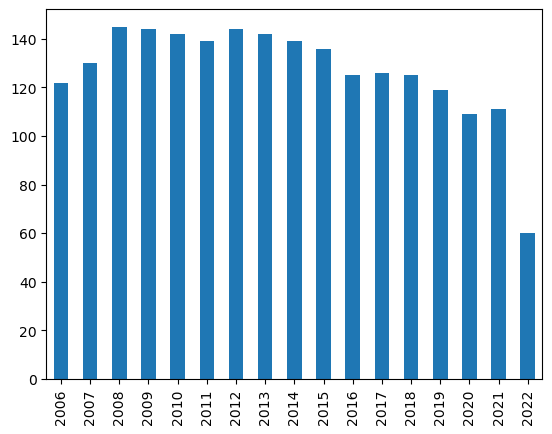

In [59]:
# Quite a few price values are still missing. I will take care of the by imputing missing values by imputing values in exchange rate time series

# Panama

df_panama=df_price_ex[df_price_ex['country']=='Panama']
df_panama['year']=df_panama['date'].dt.strftime('%Y')
df_panama['year'].value_counts().sort_index().plot(kind='bar')

<Axes: >

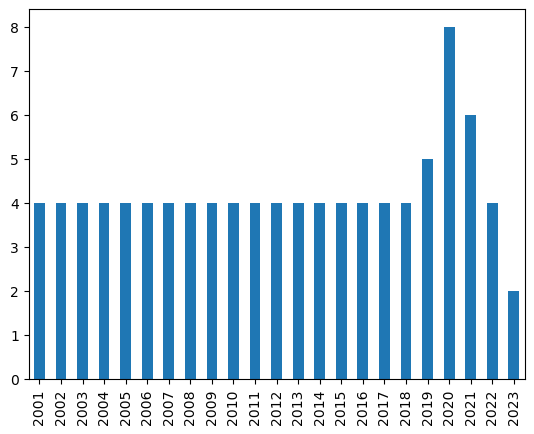

In [60]:
df_ex_panama=df_rate_final[df_rate_final['country']=='Panama']
df_ex_panama['year']=df_ex_panama['date'].dt.strftime('%Y')
df_ex_panama['year'].value_counts().sort_index().plot(kind='bar')

In [61]:
# I will impute missing exchange rates using Linear interpolation 

df_ex_panama['date']=pd.to_datetime(df_ex_panama['year_month'])
df_panama_times=df_ex_panama[['date','exchange_rate']]
df_panama_times

,date,exchange_rate
125,2023-06-01,1.0
310,2023-03-01,1.0
490,2022-12-01,1.0
671,2022-09-01,1.0
852,2022-06-01,1.0
...,...,...
16045,2002-03-01,1.0
16233,2001-12-01,1.0
16421,2001-09-01,1.0
16609,2001-06-01,1.0


In [62]:
# Changing date(already in datetime format) column to index

df_panama_times.set_index('date', inplace=True)

In [63]:
# Adding missing months

df_panama_time_month=df_panama_times.resample('M').first()

In [64]:
df_panama_time_month

,exchange_rate
date,
2001-03-31,1.0
2001-04-30,NaN
2001-05-31,NaN
2001-06-30,1.0
2001-07-31,NaN
...,...
2023-02-28,NaN
2023-03-31,1.0
2023-04-30,NaN


In [65]:
# Imputing values using Linear interpolation

df_panama_time_month['ex_rate']=df_panama_time_month['exchange_rate'].interpolate(method='linear')
df_panama_time_month

,exchange_rate,ex_rate
date,,
2001-03-31,1.0,1.0
2001-04-30,NaN,1.0
2001-05-31,NaN,1.0
2001-06-30,1.0,1.0
2001-07-31,NaN,1.0
...,...,...
2023-02-28,NaN,1.0
2023-03-31,1.0,1.0
2023-04-30,NaN,1.0


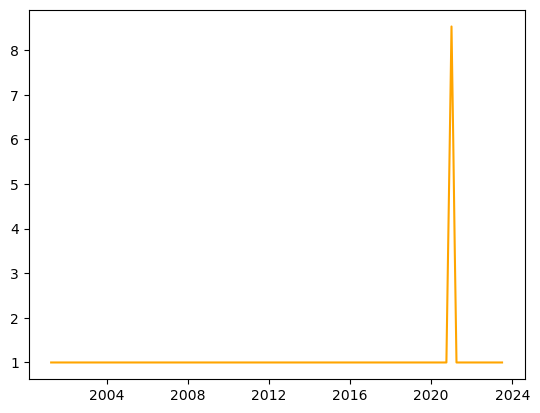

In [66]:
df_panama_filled=df_panama_time_month.drop(columns='exchange_rate')
plt.plot(df_panama_filled, color='orange')

In [67]:
df_panama_filled.reset_index(inplace=True)

In [68]:
df_panama_filled['iso']='PAN'
df_panama_filled.loc[df_panama_filled['ex_rate'].idxmax()]

date       2020-12-31 00:00:00
ex_rate                   8.53
iso                        PAN
Name: 237, dtype: object

In [69]:
df_panama_filled[df_panama_filled['ex_rate']>1.0] # all these values are inaccurate. Excange rate was around 1.1 this whole time

,date,ex_rate,iso
235,2020-10-31,3.51,PAN
236,2020-11-30,6.02,PAN
237,2020-12-31,8.53,PAN
238,2021-01-31,6.02,PAN
239,2021-02-28,3.51,PAN


In [70]:
df_panama_filled.loc[df_panama_filled['ex_rate']>1.0, 'ex_rate']=1.1

<Axes: >

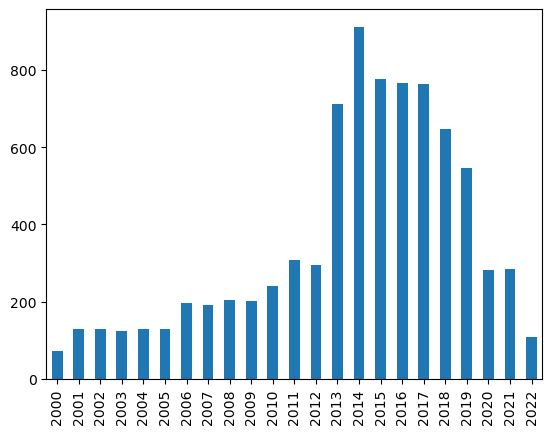

In [71]:
# NIC Nicaragua

df_nic=df_price_ex[df_price_ex['country']=='Nicaragua']
df_nic['year']=df_nic['date'].dt.strftime('%Y')
df_nic['year'].value_counts().sort_index().plot(kind='bar')

<Axes: >

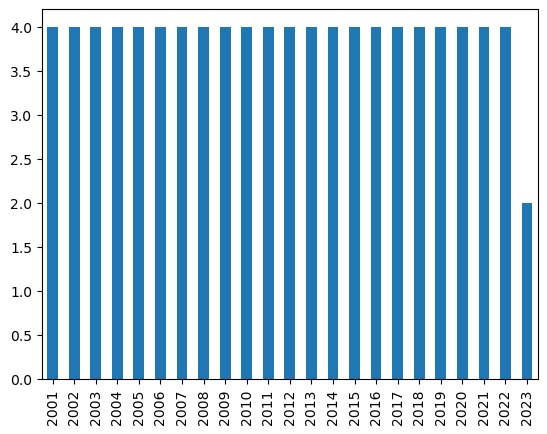

In [72]:
df_ex_nic=df_rate_final[df_rate_final['country']=='Nicaragua']
df_ex_nic['year']=df_ex_nic['date'].dt.strftime('%Y')
df_ex_nic['year'].value_counts().sort_index().plot(kind='bar')

In [73]:
# I will impute missing exchange rates using Linear interpolation 

df_ex_nic['date']=pd.to_datetime(df_ex_nic['year_month'])
df_nic_times=df_ex_nic[['date','exchange_rate']]
df_nic_times

,date,exchange_rate
118,2023-06-01,36.40
303,2023-03-01,36.30
483,2022-12-01,36.15
665,2022-09-01,36.00
846,2022-06-01,35.85
...,...,...
16039,2002-03-01,13.86
16227,2001-12-01,13.78
16415,2001-09-01,13.58
16603,2001-06-01,13.10


In [74]:
# Changing date(already in datetime format) column to index

df_nic_times.set_index('date', inplace=True)

# Adding missing months

df_nic_time_month=df_nic_times.resample('M').first()

df_nic_time_month

,exchange_rate
date,
2001-03-31,12.9
2001-04-30,NaN
2001-05-31,NaN
2001-06-30,13.1
2001-07-31,NaN
...,...
2023-02-28,NaN
2023-03-31,36.3
2023-04-30,NaN


In [75]:
# Imputing values using Linear interpolation

df_nic_time_month['ex_rate']=df_nic_time_month['exchange_rate'].interpolate(method='linear')
df_nic_time_month

,exchange_rate,ex_rate
date,,
2001-03-31,12.9,12.900000
2001-04-30,NaN,12.966667
2001-05-31,NaN,13.033333
2001-06-30,13.1,13.100000
2001-07-31,NaN,13.260000
...,...,...
2023-02-28,NaN,36.250000
2023-03-31,36.3,36.300000
2023-04-30,NaN,36.333333


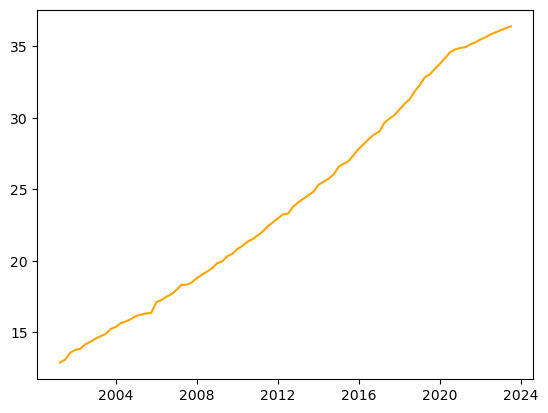

In [76]:
df_nic_filled=df_nic_time_month.drop(columns='exchange_rate')
plt.plot(df_nic_filled, color='orange')

In [77]:
df_nic_filled.reset_index(inplace=True)
df_nic_filled['iso']='NIC'
df_nic_filled

,date,ex_rate,iso
0,2001-03-31,12.900000,NIC
1,2001-04-30,12.966667,NIC
2,2001-05-31,13.033333,NIC
3,2001-06-30,13.100000,NIC
4,2001-07-31,13.260000,NIC
...,...,...,...
263,2023-02-28,36.250000,NIC
264,2023-03-31,36.300000,NIC
265,2023-04-30,36.333333,NIC
266,2023-05-31,36.366667,NIC


<Axes: >

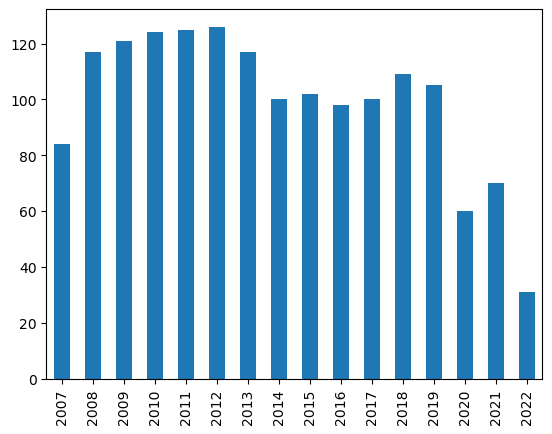

In [78]:
# HND Honduras

df_hnd=df_price_ex[df_price_ex['country']=='Honduras']
df_hnd['year']=df_hnd['date'].dt.strftime('%Y')
df_hnd['year'].value_counts().sort_index().plot(kind='bar')

<Axes: >

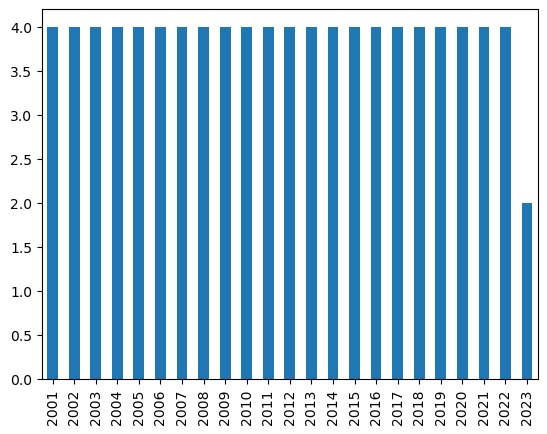

In [79]:
df_ex_hnd=df_rate_final[df_rate_final['country']=='Honduras']
df_ex_hnd['year']=df_ex_hnd['date'].dt.strftime('%Y')
df_ex_hnd['year'].value_counts().sort_index().plot(kind='bar')

In [80]:
# I will impute missing exchange rates using Linear interpolation 

df_ex_hnd['date']=pd.to_datetime(df_ex_hnd['year_month'])
df_hnd_times=df_ex_hnd[['date','exchange_rate']]
df_hnd_times

,date,exchange_rate
77,2023-06-01,24.566
263,2023-03-01,24.550
442,2022-12-01,24.552
625,2022-09-01,24.560
806,2022-06-01,24.357
...,...,...
15991,2002-03-01,16.060
16179,2001-12-01,15.854
16367,2001-09-01,15.520
16555,2001-06-01,15.380


In [81]:
# Changing date(already in datetime format) column to index

df_hnd_times.set_index('date', inplace=True)

# Adding missing months

df_hnd_time_month=df_hnd_times.resample('M').first()

df_hnd_time_month

,exchange_rate
date,
2001-03-31,15.020
2001-04-30,NaN
2001-05-31,NaN
2001-06-30,15.380
2001-07-31,NaN
...,...
2023-02-28,NaN
2023-03-31,24.550
2023-04-30,NaN


In [82]:
# Imputing values using Linear interpolation

df_hnd_time_month['ex_rate']=df_hnd_time_month['exchange_rate'].interpolate(method='linear')
df_hnd_time_month

,exchange_rate,ex_rate
date,,
2001-03-31,15.020,15.020000
2001-04-30,NaN,15.140000
2001-05-31,NaN,15.260000
2001-06-30,15.380,15.380000
2001-07-31,NaN,15.426667
...,...,...
2023-02-28,NaN,24.550667
2023-03-31,24.550,24.550000
2023-04-30,NaN,24.555333


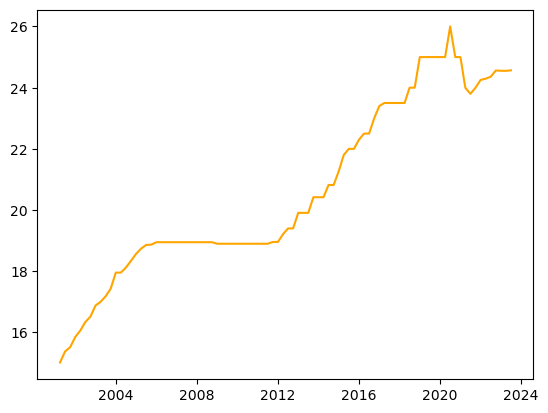

In [83]:
df_hnd_filled=df_hnd_time_month.drop(columns='exchange_rate')
plt.plot(df_hnd_filled, color='orange')

In [84]:
df_hnd_filled.reset_index(inplace=True)
df_hnd_filled['iso']='HND'
df_hnd_filled

,date,ex_rate,iso
0,2001-03-31,15.020000,HND
1,2001-04-30,15.140000,HND
2,2001-05-31,15.260000,HND
3,2001-06-30,15.380000,HND
4,2001-07-31,15.426667,HND
...,...,...,...
263,2023-02-28,24.550667,HND
264,2023-03-31,24.550000,HND
265,2023-04-30,24.555333,HND
266,2023-05-31,24.560667,HND


In [85]:
df_price_ex[(df_price_ex['price_unit'].isnull())|(df_price_ex['usdprice_unit'].isnull())]['country'].value_counts()

Nicaragua    3490
Somalia      2062
Honduras      414
Panama        100
Name: country, dtype: int64

<Axes: >

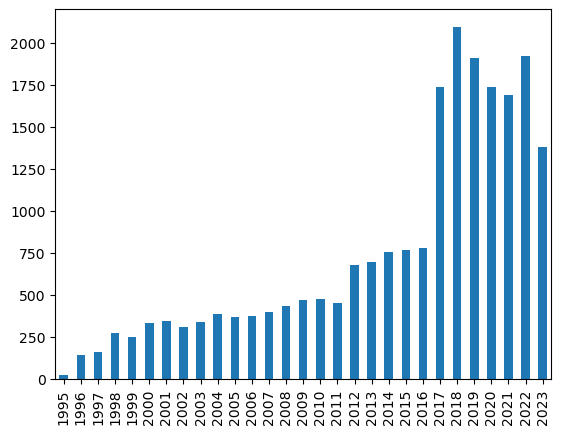

In [86]:
# Somalia SOM

df_som=df_price_ex[df_price_ex['country']=='Somalia']
df_som['year']=df_som['date'].dt.strftime('%Y')
df_som['year'].value_counts().sort_index().plot(kind='bar')

<Axes: >

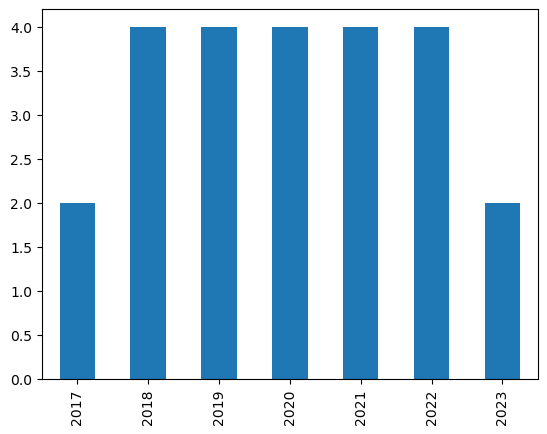

In [87]:
df_ex_som=df_rate_final[df_rate_final['country']=='Somalia']
df_ex_som['year']=df_ex_som['date'].dt.strftime('%Y')
df_ex_som['year'].value_counts().sort_index().plot(kind='bar')

In [88]:
# I will use exchange rate for Somalia that was initially included in the food price monitoring dataset

# Checking exchange rate that was originally included in the dataset

df_exchange_somalia=df_exchange[df_exchange['iso']=='SOM']

df_exchange_somalia

,date,market,latitude,longitude,category,commodity,unit,currency,price,usdprice,iso
2137666,2012-01-15,Borama,9.938690,43.183922,non-food,Exchange rate,USD/LCU,SOS,5762.0,0.2445,SOM
2137674,2012-01-15,Bakaara,2.048031,45.320000,non-food,Exchange rate,USD/LCU,SOS,25029.0,1.0620,SOM
2137677,2012-01-15,Bossaso,11.260000,49.180000,non-food,Exchange rate,USD/LCU,SOS,26500.0,1.1244,SOM
2137678,2012-01-15,Qardho,9.503070,49.088261,non-food,Exchange rate,USD/LCU,SOS,26500.0,1.1244,SOM
2137695,2012-01-15,Gaalkacyo,6.772749,47.424278,non-food,Exchange rate,USD/LCU,SOS,26525.0,1.1255,SOM
...,...,...,...,...,...,...,...,...,...,...,...
2155344,2023-07-15,Garowe,8.400000,48.480000,non-food,Exchange rate,USD/LCU,SOS,42000.0,1.7280,SOM
2155360,2023-07-15,Ceerigaabo,10.621822,47.368130,non-food,Exchange rate,USD/LCU,SOS,8600.0,NaN,SOM
2155373,2023-07-15,Balcad,2.359260,45.389641,non-food,Exchange rate,USD/LCU,SOS,27000.0,1.1109,SOM
2155466,2023-07-15,Burco,9.527490,45.537472,non-food,Exchange rate,USD/LCU,SOS,8600.0,NaN,SOM


In [89]:
df_ex_som=df_exchange_somalia[['date','price']]

df_ex_som

,date,price
2137666,2012-01-15,5762.0
2137674,2012-01-15,25029.0
2137677,2012-01-15,26500.0
2137678,2012-01-15,26500.0
2137695,2012-01-15,26525.0
...,...,...
2155344,2023-07-15,42000.0
2155360,2023-07-15,8600.0
2155373,2023-07-15,27000.0
2155466,2023-07-15,8600.0


In [90]:
df_exchange_som=df_ex_som.groupby('date', as_index=False)['price'].max()

In [91]:
df_exchange_som

,date,price
0,2012-01-15,26525.00
1,2012-02-15,25270.00
2,2012-03-15,24862.00
3,2012-04-15,24000.00
4,2012-05-15,24000.00
...,...,...
134,2023-03-15,44000.00
135,2023-04-15,42133.33
136,2023-05-15,42000.00
137,2023-06-15,42000.00


<Axes: >

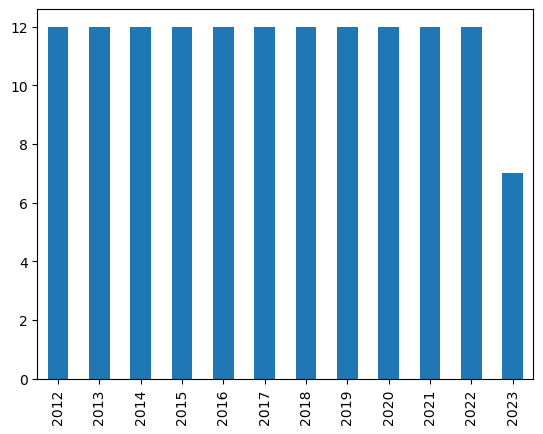

In [92]:
df_exchange_som['year']=df_exchange_som['date'].dt.strftime('%Y')
df_exchange_som['year'].value_counts().sort_index().plot(kind='bar')

# there are no missing months

In [93]:
df_exchange_som.rename(columns=({'price':'ex_rate'}), inplace=True)
df_exchange_som.drop(columns='year', inplace=True)
df_exchange_som['iso']='SOM'

In [94]:
df_exchange_som

,date,ex_rate,iso
0,2012-01-15,26525.00,SOM
1,2012-02-15,25270.00,SOM
2,2012-03-15,24862.00,SOM
3,2012-04-15,24000.00,SOM
4,2012-05-15,24000.00,SOM
...,...,...,...
134,2023-03-15,44000.00,SOM
135,2023-04-15,42133.33,SOM
136,2023-05-15,42000.00,SOM
137,2023-06-15,42000.00,SOM


In [95]:
# Combining all exchange rate datasets

df_ex_rates=pd.concat([df_exchange_som, df_hnd_filled, df_nic_filled, df_panama_filled])
df_ex_rates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 0 to 267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     943 non-null    datetime64[ns]
 1   ex_rate  943 non-null    float64       
 2   iso      943 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 29.5+ KB


In [96]:
df_ex_rates['year_month']=df_ex_rates['date'].dt.strftime('%Y-%m')

df_ex_rates.head()

,date,ex_rate,iso,year_month
0,2012-01-15,26525.0,SOM,2012-01
1,2012-02-15,25270.0,SOM,2012-02
2,2012-03-15,24862.0,SOM,2012-03
3,2012-04-15,24000.0,SOM,2012-04
4,2012-05-15,24000.0,SOM,2012-05


In [97]:
# Adding exchange rates to the main dataset

df_price_ex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2686505 entries, 0 to 2686504
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   market         object        
 2   latitude       float64       
 3   longitude      float64       
 4   category       object        
 5   commodity      object        
 6   unit           object        
 7   pricetype      object        
 8   currency       object        
 9   price          float64       
 10  usdprice       float64       
 11  iso            object        
 12  measure_unit   object        
 13  product_name   object        
 14  price_unit     float64       
 15  usdprice_unit  float64       
 16  country        object        
 17  year_month     object        
 18  exchange_rate  float64       
dtypes: datetime64[ns](1), float64(7), object(11)
memory usage: 474.4+ MB


In [98]:
df_price_ex_rates=df_price_ex.merge(df_ex_rates[['ex_rate','iso','year_month']], on=['iso','year_month'], how='left')
df_price_ex_rates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2686505 entries, 0 to 2686504
Data columns (total 20 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   market         object        
 2   latitude       float64       
 3   longitude      float64       
 4   category       object        
 5   commodity      object        
 6   unit           object        
 7   pricetype      object        
 8   currency       object        
 9   price          float64       
 10  usdprice       float64       
 11  iso            object        
 12  measure_unit   object        
 13  product_name   object        
 14  price_unit     float64       
 15  usdprice_unit  float64       
 16  country        object        
 17  year_month     object        
 18  exchange_rate  float64       
 19  ex_rate        float64       
dtypes: datetime64[ns](1), float64(8), object(11)
memory usage: 430.4+ MB


In [99]:
df_price_ex_rates.loc[(df_price_ex_rates['price_unit'].isnull())&
                (df_price_ex_rates['ex_rate'].notnull()), 'price_unit']=df_price_ex_rates['ex_rate']*df_price_ex_rates['usdprice_unit']

df_price_ex_rates.loc[(df_price_ex_rates['usdprice_unit'].isnull())&
                (df_price_ex_rates['ex_rate'].notnull()), 'usdprice_unit']=df_price_ex_rates['price_unit']/df_price_ex_rates['ex_rate']

In [100]:
df_price_ex_rates.isnull().sum()

date                   0
market                 0
latitude           23738
longitude          23738
category               0
commodity              0
unit                   0
pricetype              0
currency               0
price                  0
usdprice            2576
iso                    0
measure_unit           0
product_name           0
price_unit             0
usdprice_unit          0
country                0
year_month             0
exchange_rate    2678970
ex_rate          2658562
dtype: int64

In [101]:
df_price_full=df_price_ex_rates.drop(columns=['exchange_rate','ex_rate','price','usdprice','unit','commodity','date'])

In [102]:
df_price_ex_rates.to_pickle(os.path.join(path, 'unaggregated_all_prices.pkl'))

<a id='coordinates'></a>
### Adding missing coordinates
[Back to top](#top)

In [103]:
missing_coordinates=df_price_full[df_price_full['latitude'].isnull()]['market'].unique()
missing_coordinates

array(['National Average', 'Bichena', 'Boke',
       'National Average (excl. capital)', 'Becora', 'Numbey', 'Kombai',
       'Mandava', 'Mucheke', 'Murombedzi', 'Renkini Bus Terminus',
       'Tshovani', 'Dulibadzimu Market', 'Plumtree town'], dtype=object)

In [104]:
# Exporting a dataframe of missing data into csv file

df_missing_cor=df_price_full[df_price_full['market'].isin(missing_coordinates)]
df_miss=df_missing_cor[['market','iso','country']]
df_miss.drop_duplicates(inplace=True)
df_miss.to_csv(os.path.join(path, 'missin_coordinates.csv'))
df_miss


,market,iso,country
22145,National Average,AGO,Angola
23828,National Average,ARM,Armenia
53556,National Average,AZE,Azerbaijan
288707,National Average,BTN,Bhutan
477914,National Average,CRI,Costa Rica
485498,National Average,DOM,Dominican Republic
493877,National Average,EGY,"Egypt, Arab Rep."
511329,Bichena,ETH,Ethiopia
576855,Boke,GIN,Guinea
747686,National Average,GTM,Guatemala


In [105]:
df_price_full.head()

,market,latitude,longitude,category,pricetype,currency,iso,measure_unit,product_name,price_unit,usdprice_unit,country,year_month
0,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Bread,15.63,0.3340,Afghanistan,2000-01
1,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Wheat,9.13,0.1951,Afghanistan,2000-01
2,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Wheat flour,10.06,0.2150,Afghanistan,2000-01
3,Kabul,34.516667,69.183333,cereals and tubers,Retail,AFN,AFG,KG,Bread,14.26,0.3048,Afghanistan,2000-01
4,Kabul,34.516667,69.183333,cereals and tubers,Retail,AFN,AFG,KG,Wheat,13.75,0.2939,Afghanistan,2000-01


In [106]:
# Importing the fixed list of locations with coordinates

df_add=pd.read_csv(os.path.join(path, 'missin_coordinates_added.csv'), index_col=False)
df_add

,market,iso,country,latitude,longitude
0,National Average,AGO,Angola,-8.8383,13.2344
1,National Average,ARM,Armenia,40.153536,44.3237563
2,National Average,AZE,Azerbaijan,40.394737,40.394737
3,National Average,BTN,Bhutan,27.4833,89.6333
4,National Average,CRI,Costa Rica,9.9325,-84.0796
5,National Average,DOM,Dominican Republic,18.4764,-69.8933
6,National Average,EGY,"Egypt, Arab Rep.",30.0444,31.2358
7,Bichena,ETH,Ethiopia,?10.4500,?38.2000
8,Boke,GIN,Guinea,?10.9314,?-14.2892
9,National Average,GTM,Guatemala,14.6099,-90.5253


In [107]:
df_add.dtypes

market       object
iso          object
country      object
latitude     object
longitude    object
dtype: object

In [108]:
df_add['latitude']=df_add['latitude'].str.replace('?','')
df_add['longitude']=df_add['longitude'].str.replace('?','')

df_add['latitude']=df_add['latitude'].astype('float')
df_add['longitude']=df_add['longitude'].astype('float')

df_add.dtypes

C:\Users\frauz\AppData\Local\Temp\ipykernel_17328\2006702039.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_add['latitude']=df_add['latitude'].str.replace('?','')
C:\Users\frauz\AppData\Local\Temp\ipykernel_17328\2006702039.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_add['longitude']=df_add['longitude'].str.replace('?','')


market        object
iso           object
country       object
latitude     float64
longitude    float64
dtype: object

In [109]:
df_add.dtypes

market        object
iso           object
country       object
latitude     float64
longitude    float64
dtype: object

In [110]:
# Merging the new coordinates into the main dataframe. Rows 2686505

df_price_fixed=df_price_full.merge(df_add, on=['iso','market','country'], how='left')
df_price_fixed

,market,latitude_x,longitude_x,category,pricetype,currency,iso,measure_unit,product_name,price_unit,usdprice_unit,country,year_month,latitude_y,longitude_y
0,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Bread,15.6300,0.3340,Afghanistan,2000-01,NaN,NaN
1,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Wheat,9.1300,0.1951,Afghanistan,2000-01,NaN,NaN
2,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Wheat flour,10.0600,0.2150,Afghanistan,2000-01,NaN,NaN
3,Kabul,34.516667,69.183333,cereals and tubers,Retail,AFN,AFG,KG,Bread,14.2600,0.3048,Afghanistan,2000-01,NaN,NaN
4,Kabul,34.516667,69.183333,cereals and tubers,Retail,AFN,AFG,KG,Wheat,13.7500,0.2939,Afghanistan,2000-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686500,Nkayi Growth Point,-18.999158,28.898316,non-food,Retail,USD,ZWE,KG,Handwash soap,1.5336,1.5336,Zimbabwe,2023-01,NaN,NaN
2686501,Nkayi Growth Point,-18.999158,28.898316,non-food,Retail,USD,ZWE,KG,Laundry soap,1.9280,1.9280,Zimbabwe,2023-01,NaN,NaN
2686502,Nkayi Growth Point,-18.999158,28.898316,non-food,Retail,USD,ZWE,L,Toothpaste,19.1700,19.1700,Zimbabwe,2023-01,NaN,NaN
2686503,Nkayi Growth Point,-18.999158,28.898316,oil and fats,Retail,USD,ZWE,L,Oil,2.7386,2.7386,Zimbabwe,2023-01,NaN,NaN


In [111]:
df_price_fixed.loc[(df_price_fixed['latitude_x'].isnull())&
                   (df_price_fixed['latitude_y'].notnull()), 'latitude_x']=df_price_fixed['latitude_y']

df_price_fixed.loc[(df_price_fixed['longitude_x'].isnull())&
                   (df_price_fixed['longitude_y'].notnull()), 'longitude_x']=df_price_fixed['longitude_y']

df_price_fixed.isnull().sum()

market                 0
latitude_x             0
longitude_x            0
category               0
pricetype              0
currency               0
iso                    0
measure_unit           0
product_name           0
price_unit             0
usdprice_unit          0
country                0
year_month             0
latitude_y       2662767
longitude_y      2662767
dtype: int64

In [112]:
# Removing the copied columns

df_price_fixed.drop(columns=['latitude_y','longitude_y'], inplace=True)



df_price_fixed.rename(columns=({'latitude_x':'latitude','longitude_x':'longitude'}), inplace=True)
df_price_fixed

,market,latitude,longitude,category,pricetype,currency,iso,measure_unit,product_name,price_unit,usdprice_unit,country,year_month
0,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Bread,15.6300,0.3340,Afghanistan,2000-01
1,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Wheat,9.1300,0.1951,Afghanistan,2000-01
2,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Wheat flour,10.0600,0.2150,Afghanistan,2000-01
3,Kabul,34.516667,69.183333,cereals and tubers,Retail,AFN,AFG,KG,Bread,14.2600,0.3048,Afghanistan,2000-01
4,Kabul,34.516667,69.183333,cereals and tubers,Retail,AFN,AFG,KG,Wheat,13.7500,0.2939,Afghanistan,2000-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686500,Nkayi Growth Point,-18.999158,28.898316,non-food,Retail,USD,ZWE,KG,Handwash soap,1.5336,1.5336,Zimbabwe,2023-01
2686501,Nkayi Growth Point,-18.999158,28.898316,non-food,Retail,USD,ZWE,KG,Laundry soap,1.9280,1.9280,Zimbabwe,2023-01
2686502,Nkayi Growth Point,-18.999158,28.898316,non-food,Retail,USD,ZWE,L,Toothpaste,19.1700,19.1700,Zimbabwe,2023-01
2686503,Nkayi Growth Point,-18.999158,28.898316,oil and fats,Retail,USD,ZWE,L,Oil,2.7386,2.7386,Zimbabwe,2023-01


In [113]:
# Checking if the same coordinates are used for the same market locations

df_price_fixed.groupby('market')['longitude'].nunique().sort_values(ascending=False)

#some markets have different coordinates entered

market
National Average    26
Haoussa Foulane      2
Der Hafir            2
Forgho               2
Hawash               2
                    ..
Hpasaung             1
Hrak                 1
Hrazdan              1
Hsihseng             1
Échelle              1
Name: longitude, Length: 3633, dtype: int64

In [114]:
# Marking markets that have 2 sets of coordinates

df_price_fixed['market_count']=df_price_fixed.groupby('market')['longitude'].transform('nunique')
df_price_fixed.head()

,market,latitude,longitude,category,pricetype,currency,iso,measure_unit,product_name,price_unit,usdprice_unit,country,year_month,market_count
0,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Bread,15.63,0.3340,Afghanistan,2000-01,1
1,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Wheat,9.13,0.1951,Afghanistan,2000-01,1
2,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Wheat flour,10.06,0.2150,Afghanistan,2000-01,1
3,Kabul,34.516667,69.183333,cereals and tubers,Retail,AFN,AFG,KG,Bread,14.26,0.3048,Afghanistan,2000-01,1
4,Kabul,34.516667,69.183333,cereals and tubers,Retail,AFN,AFG,KG,Wheat,13.75,0.2939,Afghanistan,2000-01,1


In [115]:
df_price_fixed.loc[df_price_fixed['market_count']==2]['market'].value_counts()

Qudsiya            3308
Quamishli          3294
Rural Safita       3170
Deir-ez-Zor        3133
Idleb              2966
Muhanga            2531
A'zaz              2118
Muhradah           1861
Hawash             1852
Der Hafir          1745
Aba                1610
Gatore             1138
Al Waer             842
Sikasso Médine      808
Ein Terma           797
Forgho              714
Haoussa Foulane     708
San Vicente         538
Rosso                54
Name: market, dtype: int64

In [116]:
# Finding the most common latitude and longitude for each market 

df_price_fixed['longitude_mode']=df_price_fixed.groupby('market')['longitude'].transform(lambda x: x.value_counts().idxmax())
df_price_fixed['latitude_mode']=df_price_fixed.groupby('market')['latitude'].transform(lambda x: x.value_counts().idxmax())
df_price_fixed.head()

,market,latitude,longitude,category,pricetype,currency,iso,measure_unit,product_name,price_unit,usdprice_unit,country,year_month,market_count,longitude_mode,latitude_mode
0,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Bread,15.63,0.3340,Afghanistan,2000-01,1,62.198333,34.346944
1,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Wheat,9.13,0.1951,Afghanistan,2000-01,1,62.198333,34.346944
2,Hirat,34.346944,62.198333,cereals and tubers,Retail,AFN,AFG,KG,Wheat flour,10.06,0.2150,Afghanistan,2000-01,1,62.198333,34.346944
3,Kabul,34.516667,69.183333,cereals and tubers,Retail,AFN,AFG,KG,Bread,14.26,0.3048,Afghanistan,2000-01,1,69.183333,34.516667
4,Kabul,34.516667,69.183333,cereals and tubers,Retail,AFN,AFG,KG,Wheat,13.75,0.2939,Afghanistan,2000-01,1,69.183333,34.516667


In [117]:
# Unifying all coordinates

df_price_fixed.loc[df_price_fixed['market_count']==2, 'latitude']=df_price_fixed['latitude_mode']

df_price_fixed.loc[df_price_fixed['market_count']==2, 'longitude']=df_price_fixed['longitude_mode']

# Checking if the same coordinates are used for the same market locations

df_price_fixed.groupby('market')['longitude'].nunique().sort_values(ascending=False)
#except for national average, all markets onl have 1 coordinates value

market
National Average    26
88 ward              1
Nemamwa              1
Ndugu Kebbeh         1
Ndélé                1
                    ..
Hoshangabad          1
Hossana              1
Houndé               1
Hozin                1
Échelle              1
Name: longitude, Length: 3633, dtype: int64

In [118]:
df_price_fixed.isnull().sum()

market            0
latitude          0
longitude         0
category          0
pricetype         0
currency          0
iso               0
measure_unit      0
product_name      0
price_unit        0
usdprice_unit     0
country           0
year_month        0
market_count      0
longitude_mode    0
latitude_mode     0
dtype: int64

In [119]:
df_price_fixed.duplicated().sum()

70091

In [120]:
df_price_fixed.drop_duplicates(inplace=True)
df_price_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2616414 entries, 0 to 2686504
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   market          object 
 1   latitude        float64
 2   longitude       float64
 3   category        object 
 4   pricetype       object 
 5   currency        object 
 6   iso             object 
 7   measure_unit    object 
 8   product_name    object 
 9   price_unit      float64
 10  usdprice_unit   float64
 11  country         object 
 12  year_month      object 
 13  market_count    int64  
 14  longitude_mode  float64
 15  latitude_mode   float64
dtypes: float64(6), int64(1), object(9)
memory usage: 339.3+ MB


In [121]:
df_price_fixed.drop(columns=['market_count','longitude_mode','latitude_mode'], inplace=True)

In [122]:
df_price_fixed.to_pickle(os.path.join(path, 'market_duplicates_deleted_non_agg.pickle'))

In [123]:
df_price_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2616414 entries, 0 to 2686504
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   market         object 
 1   latitude       float64
 2   longitude      float64
 3   category       object 
 4   pricetype      object 
 5   currency       object 
 6   iso            object 
 7   measure_unit   object 
 8   product_name   object 
 9   price_unit     float64
 10  usdprice_unit  float64
 11  country        object 
 12  year_month     object 
dtypes: float64(4), object(9)
memory usage: 279.5+ MB


<a id='agg'></a>
### Aggregating average price for the same product-day-market-country
[Back to top](#top)

In [124]:
#There are several records for the same products made in the same month at the same market. 

df_price_fin_ver=df_price_fixed.groupby(['iso', 
                                         'country',
                                          'market',
                                           'latitude',
                                           'longitude',
                                           'year_month',
                                            'pricetype',
                                            'category',
                                             'currency',
                                             'measure_unit',
                                             'product_name']).agg({'price_unit':'mean','usdprice_unit':'mean'})

df_price_fin_ver.reset_index(inplace=True)

df_price_fin_ver.head()

,iso,country,market,latitude,longitude,year_month,pricetype,category,currency,measure_unit,product_name,price_unit,usdprice_unit
0,AFG,Afghanistan,Badakhshan,37.03785,70.45621,2020-05,Retail,cereals and tubers,AFN,KG,Bread,50.00,0.65360
1,AFG,Afghanistan,Badakhshan,37.03785,70.45621,2020-05,Retail,cereals and tubers,AFN,KG,Rice,82.75,1.08165
2,AFG,Afghanistan,Badakhshan,37.03785,70.45621,2020-05,Retail,cereals and tubers,AFN,KG,Wheat,31.00,0.40520
3,AFG,Afghanistan,Badakhshan,37.03785,70.45621,2020-05,Retail,cereals and tubers,AFN,KG,Wheat flour,39.50,0.51635
4,AFG,Afghanistan,Badakhshan,37.03785,70.45621,2020-05,Retail,miscellaneous food,AFN,KG,Salt,25.00,0.32680


In [125]:
df_price_fin_ver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164814 entries, 0 to 2164813
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   iso            object 
 1   country        object 
 2   market         object 
 3   latitude       float64
 4   longitude      float64
 5   year_month     object 
 6   pricetype      object 
 7   category       object 
 8   currency       object 
 9   measure_unit   object 
 10  product_name   object 
 11  price_unit     float64
 12  usdprice_unit  float64
dtypes: float64(4), object(9)
memory usage: 214.7+ MB


In [126]:
df_price_fin_ver.isnull().sum()

iso              0
country          0
market           0
latitude         0
longitude        0
year_month       0
pricetype        0
category         0
currency         0
measure_unit     0
product_name     0
price_unit       0
usdprice_unit    0
dtype: int64

In [127]:
df_price_fin_ver.duplicated().sum()

0

In [128]:
df_price_fin_ver['date']=pd.to_datetime(df_price_fin_ver['year_month'])
df_price_fin_ver.head()

,iso,country,market,latitude,longitude,year_month,pricetype,category,currency,measure_unit,product_name,price_unit,usdprice_unit,date
0,AFG,Afghanistan,Badakhshan,37.03785,70.45621,2020-05,Retail,cereals and tubers,AFN,KG,Bread,50.00,0.65360,2020-05-01
1,AFG,Afghanistan,Badakhshan,37.03785,70.45621,2020-05,Retail,cereals and tubers,AFN,KG,Rice,82.75,1.08165,2020-05-01
2,AFG,Afghanistan,Badakhshan,37.03785,70.45621,2020-05,Retail,cereals and tubers,AFN,KG,Wheat,31.00,0.40520,2020-05-01
3,AFG,Afghanistan,Badakhshan,37.03785,70.45621,2020-05,Retail,cereals and tubers,AFN,KG,Wheat flour,39.50,0.51635,2020-05-01
4,AFG,Afghanistan,Badakhshan,37.03785,70.45621,2020-05,Retail,miscellaneous food,AFN,KG,Salt,25.00,0.32680,2020-05-01


In [130]:
# Exporting the data

df_price_fin_ver.to_pickle(os.path.join(path, 'market_level_data_clean_aggregated.pkl'))
df_price_fin_ver.to_csv(os.path.join(path, 'market_level_data_clean_aggregated.csv'))